<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font> 

<div class="alert alert-block alert-warning">
    
# Assignment

Welcome to task 2 of the assignment! This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook__

<b>Enter you student details below</b>

- <b>Student Name:</b> Lucas Liu
- <b>Student ID:</b> 31445179

<div class="alert alert-block alert-danger">

# Table of Contents
    
* [Libraries](#Libraries)
    
* [Task 2.1: Create dataloader for Face Data and Visualise a few samples](#t2_1)
    
* [Task 2.2: Design your network architecture for AE](#t2_2)
    
* [Task 2.3: Train your model and evaluate the DAE results](#t2_3)
    
* [Task 2.4: Visualise reconstructed images along with the clean data](#t2_4)
    
* [Task 2.5: Compute Peak Signal To Noise Ratio (PSNR)](#t2_5)
    
* [Task 2.6: Discussion Question](#t2_6)

<div class="alert alert-block alert-warning">

# Libraries

Libraries are important as it saves us time from writing our own functions all the time such as graphing, or creating matrices. Brief library descriptions have been added for every library that we import. You may also check the official documentations for more details.

The required libraries are specified in this notebook for you.

In [3]:
# Mount Google Drive
import os

try:
    from google.colab import drive

    colabFlag = True

    PATH_DATASETS = "/content/gdrive/MyDrive/..."  # Add in your own path here to the folder containing the data
    # mount Google Drive
    drive.mount("/content/gdrive")
    print(f"Using Google Colab with file path {PATH_DATASETS}")
except:
    colabFlag = False

    PATH_DATASETS = os.environ.get("PATH_DATASETS", "./data")

    print(f"Not using Google Colab. File path will be: {PATH_DATASETS}")

Not using Google Colab. File path will be: ./data


In [4]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

import torch
import torchmetrics
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl  # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"


BATCH_SIZE = 256 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else "cpu")
num_workers = 0  # Set to your device

Seed set to 4179


<div class="alert alert-block alert-info">

# DAE: Denoising Autoencoder
    
## What you should do in this task!

In this task you will be training an autoencoder to denoise images using Pytorch and PyTorch Lightning functionalities we have previously encountered!

Use Pytorch and the Pytorch Lightning module class to create an autoencoder architecture in order to denoise (noisy) face data, and train your model using ADAM. The image below shows a denoising autoencoder applied to the MNIST dataset

<img src="figures/denoising_ae_image.png" width="700" align="center">
    
#### In this task, you will work on the following points:
 1. Prepare the dataset and create dataloaders.
 2. Visualise a training sample using the dataloader.
 3. Design the neural network model.
 4. Perform training of the model and evaluation.
 5. Visualise experimental results.
    


<div class="alert alert-block alert-info">

### Task 2.1: Create dataloader for Face Data and Visualise a few samples <a class="anchor" id="t2_1"></a>

Use the **random_split** function to divide the training dataset into Train, Validation and Test. You must use 20% of the training data as Validation data during training and keep 20% as Testing data.

In [5]:
# Create your class for the face data
# The face data can be reshaped into the shape of (N, 64, 64) where N is the size of the dataset
# It is always recommended to print the shape of the numpy array before reshaping, just to ensure the dimensions are correct


class FaceData(Dataset):
    def __init__(self, transform=None):
        self.images = np.load(PATH_DATASETS + "/face_data.npy")

        # Define your self.images and self.transform
        # Are there labels in this dataset? Think about what the task is and why there may (or may not be) labels
        self.images = self.images.reshape(-1, 64, 64)
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        sample = self.images[idx, :, :]

        # If there is a transform, apply it here to your sample
        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
# data transform without data augmentation
data_transform = transforms.Compose(
    [
        transforms.ToPILImage(),  # PIL [Python Imaging Library] is a Python package to read images. This allows you to use the resize transform.
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(0, 1),
    ]
)

# Load in dataloader
train_set = FaceData(transform=data_transform)

# Split the train set into training, validation and test
train_set, val_set = random_split(
    train_set, [int(len(train_set) * 0.6), len(train_set) - int(len(train_set) * 0.6)]
)
val_set, test_set = random_split(
    val_set, [int(len(val_set) * 0.5), len(val_set) - int(len(val_set) * 0.5)]
)

# Create Dataloaders again with features generated from pre-trained CNN model
train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers
)
valid_loader = DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers
)
test_loader = DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers
)

Let's add some noise to the data samples!

(-0.5, 273.5, 1089.5, -0.5)

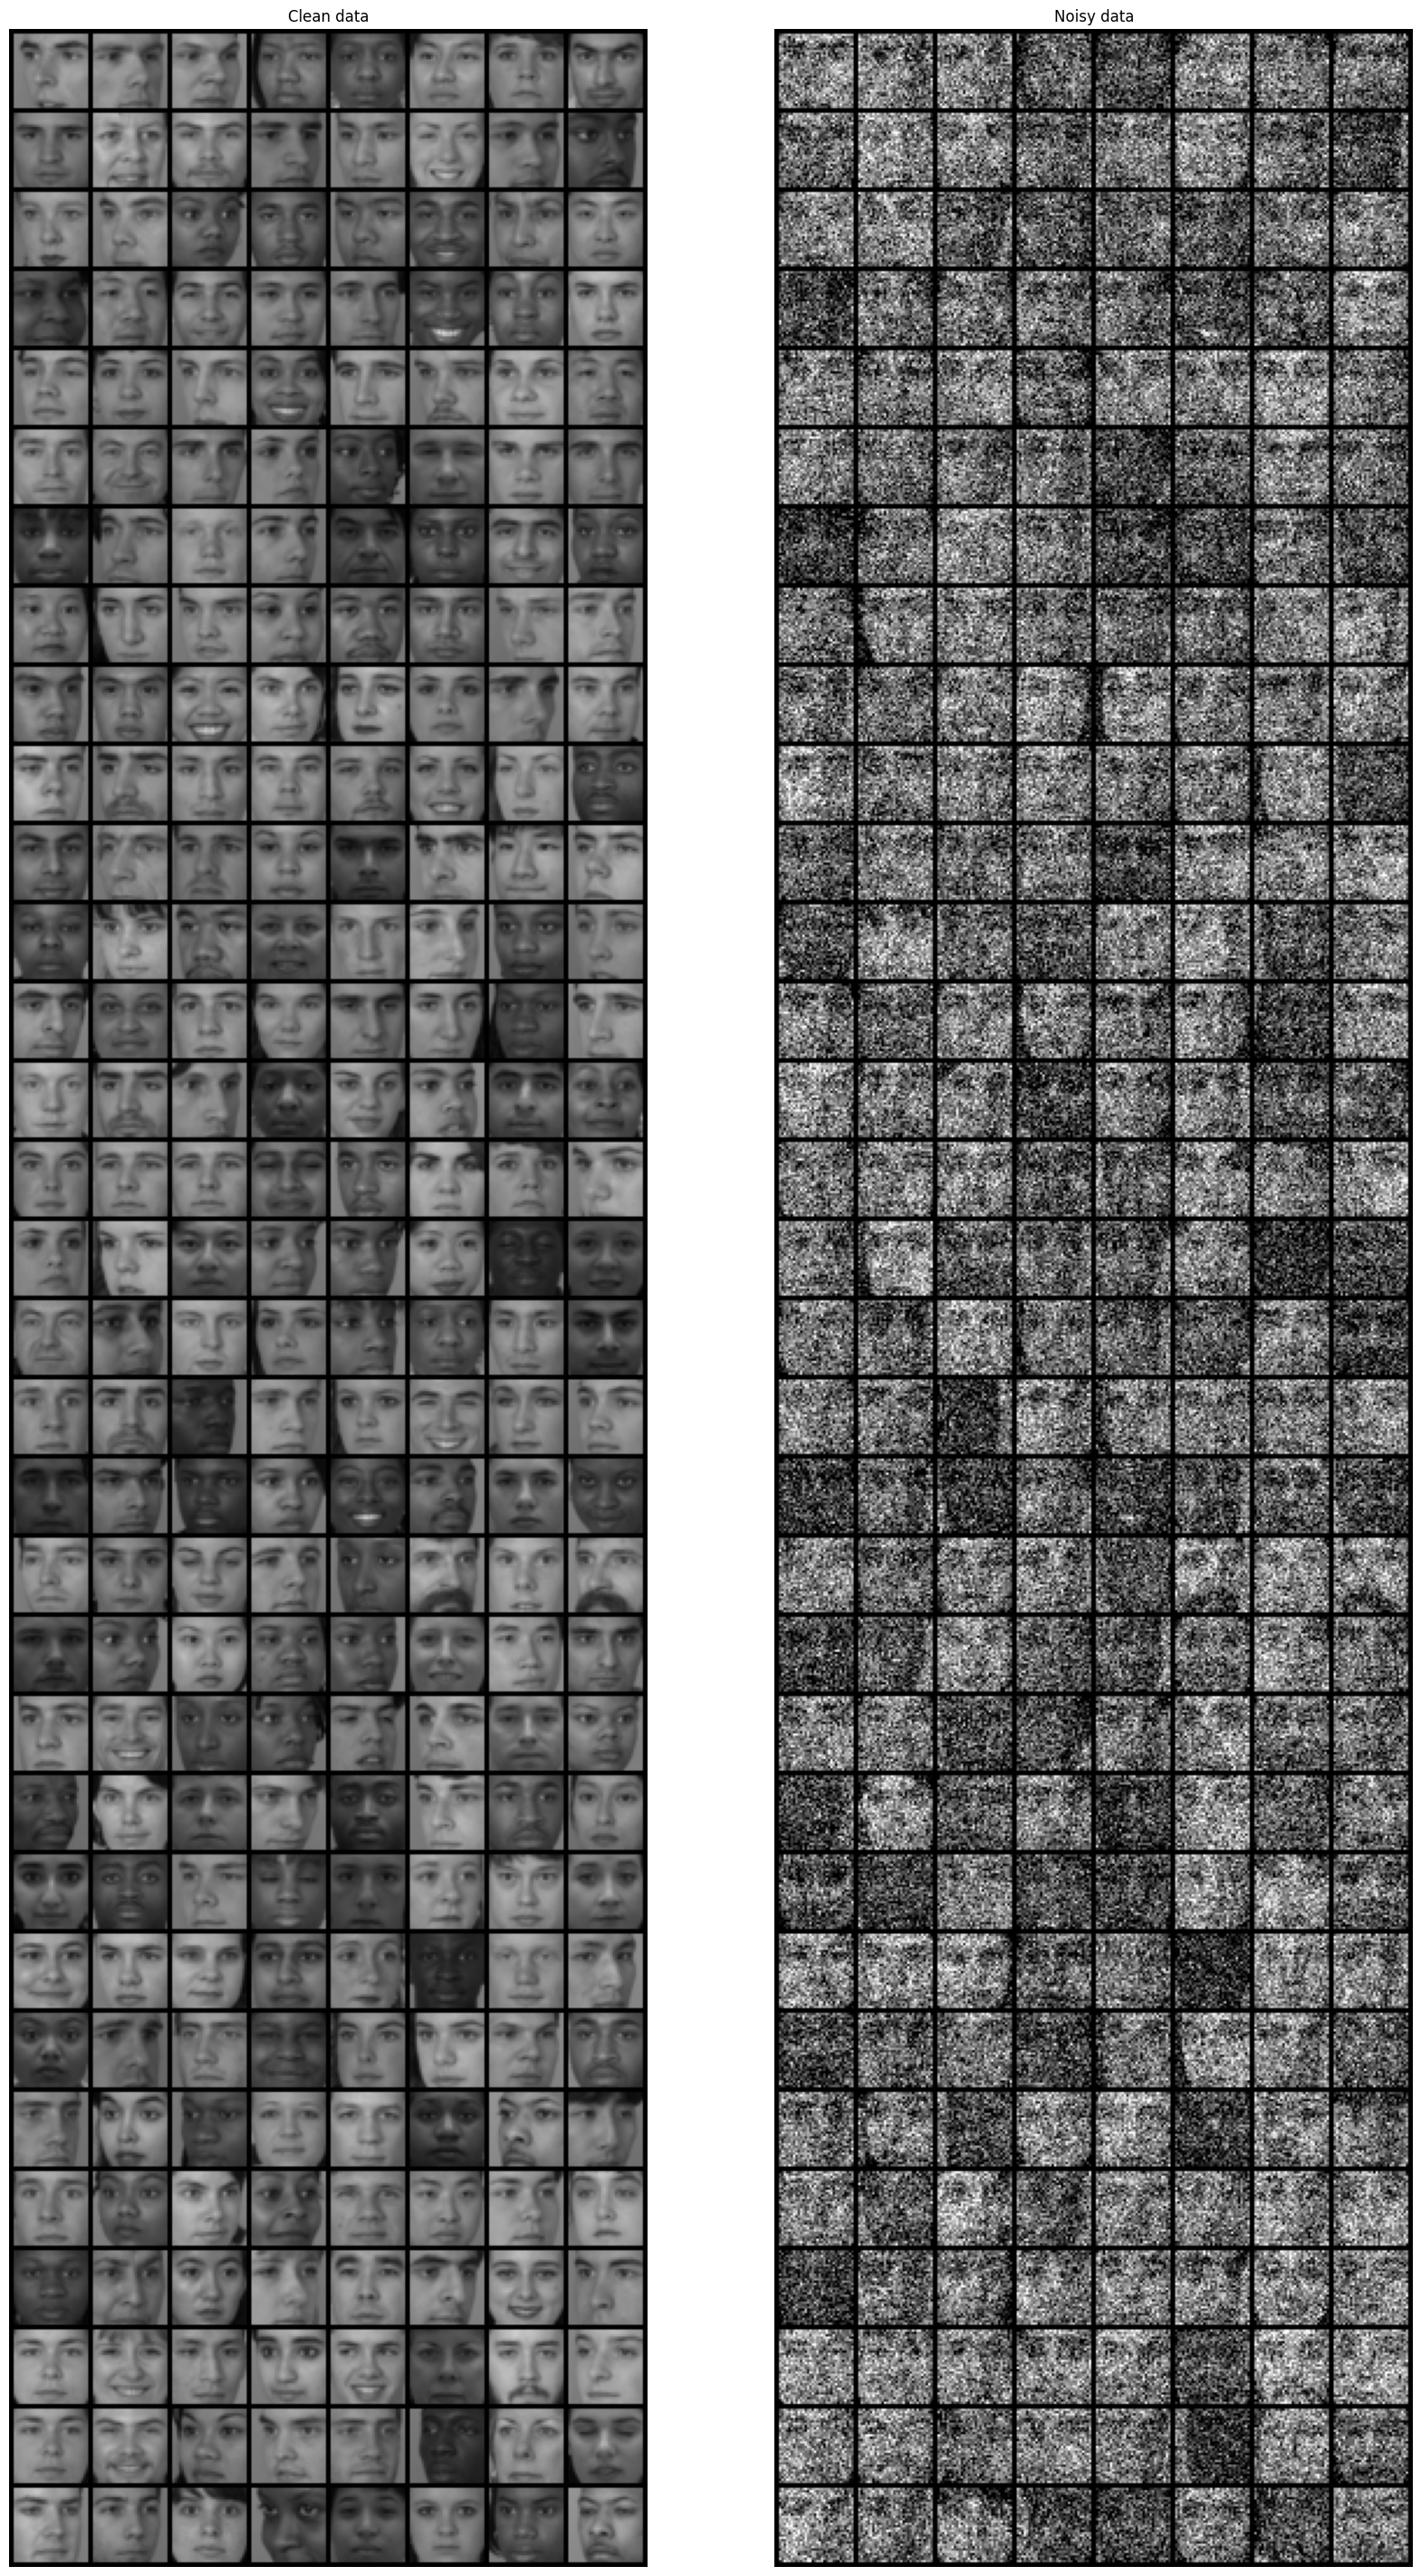

In [7]:
# Create noisy samples by noise_percentage * torch.randn_like(data0).
# You can use torch.randn_like(data) * noise_percentage to generate noise based around the data's distribution
# These will just be temporary noisy images. You will add in the noise during the training_step of your Simple_AE class later on.

data = next(iter(train_loader))

# Create noisy data
noise_percentage = 0.2
noisy_data = noise_percentage * torch.randn_like(data) + data
noisy_data = torch.clip(
    noisy_data, 0.0, 1.0
)  # Clip the data between 0 and 1. Look at the documentation for torch.clip()

# visualize clean dataset using torchvision grid
grid = torchvision.utils.make_grid(data)
plt.figure(figsize=(20, 80))
plt.subplot(1, 2, 1)
plt.title("Clean data")
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")

# visualize noisy dataset using torchvision grid
grid = torchvision.utils.make_grid(noisy_data)
plt.subplot(1, 2, 2)
plt.title("Noisy data")
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")

<div class="alert alert-block alert-info">
    
### Task 2.2: Design your network architecture for AE <a class="anchor" id="t2_2"></a>

In this task, you will create the encoder and decoder modules that you will use within your "Simple_AE" class (which will be your DAE).

The encoder will just consist of one layer with an activation function. BatchNorm1d will also be added to the encoder to speed up convergence. The decoder will also be one layer but has no activation function. You do not need to put a BatchNorm1d here.

The rest of the hyperparameters can be found within the PDF.

_Note: We have provided additional optional material in the weekly lectures for batch normalization if you wish to learn more about it. This is a useful technique in speeding up training. To use BatchNorm1d, you simply have to put in the previous layer's number of input features as the input parameter. See the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for more information._

In [8]:
# Define your encoder class
# You will use one linear layer in the encoder class and pass it through BatchNorm1d() then LeakyReLU


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder section

        # Define linear layer

        self.encoder = nn.Sequential(
            # Add Linear Layer
            nn.Linear(32 * 32, 128),
            # Add BatchNorm1d() as the next one in the sequence.
            nn.BatchNorm1d(128),
            # Then add LeakyReLU. Note BatchNorm1d takes an input argument.
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        # Forward pass of your encoder
        x = x.view(x.size(0), -1)
        x = self.encoder(x)

        return x


# Define your decoder class
# You will use one linear layer in the encoder class. No need for LeakyReLU because we have a sigmoid at the end


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Add Linear Layer

        # Decoder section
        self.decoder = nn.Sequential(
            # Add Linear Layer
            nn.Linear(128, 32 * 32),
        )

    def forward(self, x):
        # Forward pass through your decoder
        # Pass the output of your decoder into a sigmoid function
        # Ensure you reshape to B x C x H x W before returning the values
        x = self.decoder(x)
        x = nn.functional.sigmoid(x)
        x = x.view(x.size(0), 1, 32, 32)

        return x

Create your autoencoder class '_Simple_AE_' using LightningModule and call the Encoder and Decoder Blocks you have defined above.

In [9]:
# Let's create a simple DAE based on MLP networks
class Simple_AE(pl.LightningModule):

    def __init__(self, learning_rate=1e-3, weight_decay=1e-5, loss="l1"):
        super().__init__()

        self.learning_rate = learning_rate  # Use learning rate provided
        self.weight_decay = weight_decay  # Use weight decay provided
        if loss == "l1":
            self.criterion = nn.L1Loss()  # Use L1 loss as the criterion
        elif loss == "mse":
            self.criterion = nn.MSELoss()

        self.encoder = Encoder()  # Initialise your encoder
        self.decoder = Decoder()  # Initialise your decoder

    def forward(self, x):
        # Forward pass through encoder and decoder
        # Is the result the same shape as your original image? Worth to double check!
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def training_step(
        self, batch, batch_idx
    ):  # There are additional steps here compared to previous implementations of your NN models. Read the comments carefully!
        y: torch.Tensor = batch
        noisy_data = noise_percentage * torch.randn_like(y) + y
        noisy_data = torch.clip(noisy_data, 0.0, 1.0)

        # Remember, this is where we are training. So you will pass in your noisy_data to the encoder, and use that latent code to pass through your decoder
        denoised = self(noisy_data)

        loss = self.criterion(denoised, y)
        # If your model is not converging to a non-noisy output, this loss criterion might be why! (perhaps comparing two wrong values)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

        return loss  # Don't forget to return loss so that the gradients can be updated

    def validation_step(
        self, batch, batch_idx
    ):  # There are additional steps here compared to previous implementations of your NN models. Read the comments carefully!
        y: torch.Tensor = batch
        noisy_data = noise_percentage * torch.randn_like(y) + y
        noisy_data = torch.clip(noisy_data, 0.0, 1.0)

        denoised = self(noisy_data)

        loss = self.criterion(denoised, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)

    def test_step(
        self, batch, batch_idx
    ):  # There are additional steps here compared to previous implementations of your NN models. Read the comments carefully!
        y: torch.Tensor = batch
        noisy_data = noise_percentage * torch.randn_like(y) + y
        noisy_data = torch.clip(noisy_data, 0.0, 1.0)

        denoised = self(noisy_data)

        loss = self.criterion(denoised, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)

    def predict_step(
        self, batch, batch_idx
    ):  # There are additional steps here compared to previous implementations of your NN models. Read the comments carefully!
        # You need to return predicted "x", noisy "x", and original x. That way you can compare the results with what is expected  !
        y: torch.Tensor = batch
        noisy_data = noise_percentage * torch.randn_like(y) + y
        noisy_data = torch.clip(noisy_data, 0.0, 1.0)

        denoised = self(noisy_data)

        return denoised, noisy_data, y

    def configure_optimizers(self):

        return torch.optim.Adam(
            self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay
        )

    #####################
    # DATA RELATED HOOKS
    #####################

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

<div class="alert alert-block alert-info">
    
### Task 2.3: Train your model and evaluate the DAE results <a class="anchor" id="t2_3"></a>

In [16]:
# Initialize the model
from pytorch_lightning.utilities.model_summary.model_summary import ModelSummary

model_ae = Simple_AE(learning_rate=1e-3, weight_decay=1e-5)

print(ModelSummary(model_ae))

losses = ["l1", "mse"]

for loss in losses:
    # Define checkpoint callback function to save best model
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_task_2/",
        enable_version_counter=False,
        filename=f"task_2_model_{loss}",
        save_top_k=1,  # save the best model
        mode="min",
        every_n_epochs=1,
    )

    # Call the Trainer and train the model
    trainer_task = pl.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=50,
        callbacks=[checkpoint_callback],
        logger=CSVLogger(save_dir="logs_task_2/", name=loss, version=0),
    )
    # Train the Simple AE model
    # trainer_task.fit(model_ae)
    # Deleted output because of scuffed tqdm progress bar outputs

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | L1Loss  | 0      | train
1 | encoder   | Encoder | 131 K  | train
2 | decoder   | Decoder | 132 K  | train
----------------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


In [87]:
# Test the model and report test accuracy and test loss
params = torch.load("checkpoints_task_2/task_2_model_l1.ckpt")  # Load the best model
model_ae.load_state_dict(params["state_dict"])
trainer_task.test(model_ae)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/lucas/code/ece4179-neural-networks/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.0397338829934597
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0397338829934597}]

Visiualise your experimental results. First, take a look at the accuracy for both training and validation. 

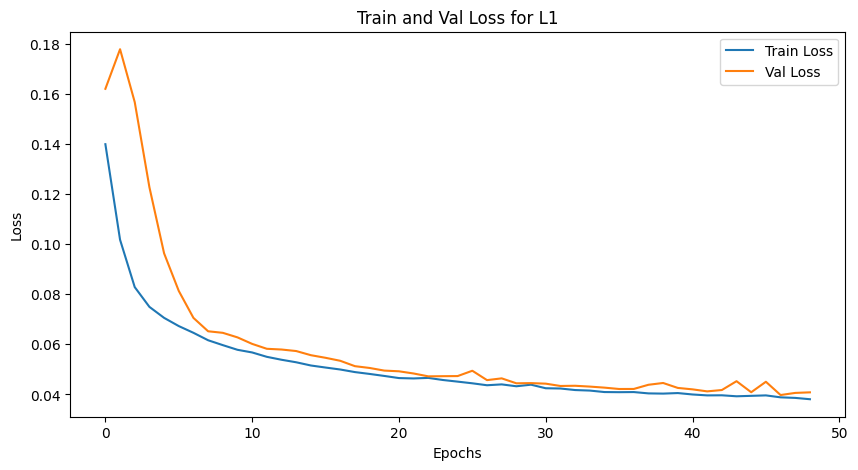

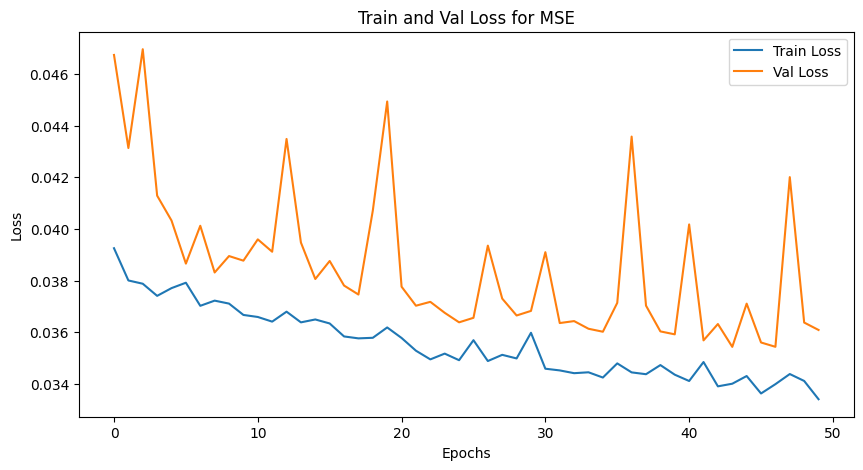

In [97]:
# Plot both training and validation losses

data = pd.read_csv("logs_task_2/l1/version_0/metrics.csv")
data = data.groupby("epoch").sum().drop(columns=["step"])
plt.figure(figsize=(10, 5))
plt.plot(data["train_loss"][:-1], label="Train Loss")
plt.plot(data["val_loss"][:-1], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Val Loss"])
plt.title("Train and Val Loss for L1")
plt.show()

data = pd.read_csv("logs_task_2/mse/version_0/metrics.csv")
data = data.groupby("epoch").sum().drop(columns=["step"])
plt.figure(figsize=(10, 5))
plt.plot(data["train_loss"][:-1], label="Train Loss")
plt.plot(data["val_loss"][:-1], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Val Loss"])
plt.title("Train and Val Loss for MSE")
plt.show()

<div class="alert alert-block alert-info">
    
### Task 2.4: Visualise reconstructed images along with the clean data <a class="anchor" id="t2_4"></a>
    
Visualise some reconstructed images along with clean data and noisy data. You can use the predict function from your trainer. Reshape your output accordingly so that it is the same as the input image dimensions. Please plot at least 20 images, and make sure label your visualisations appropriately.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/lucas/code/ece4179-neural-networks/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

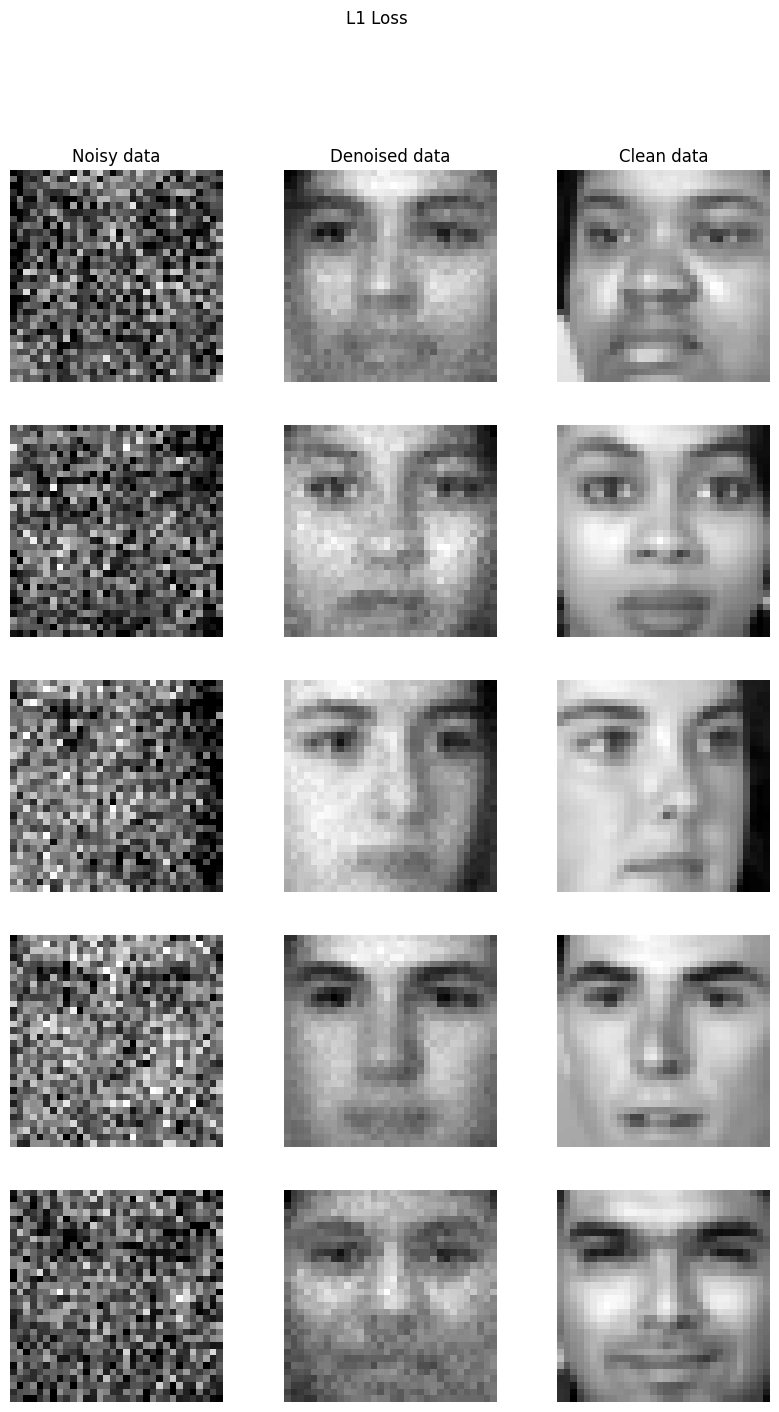

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

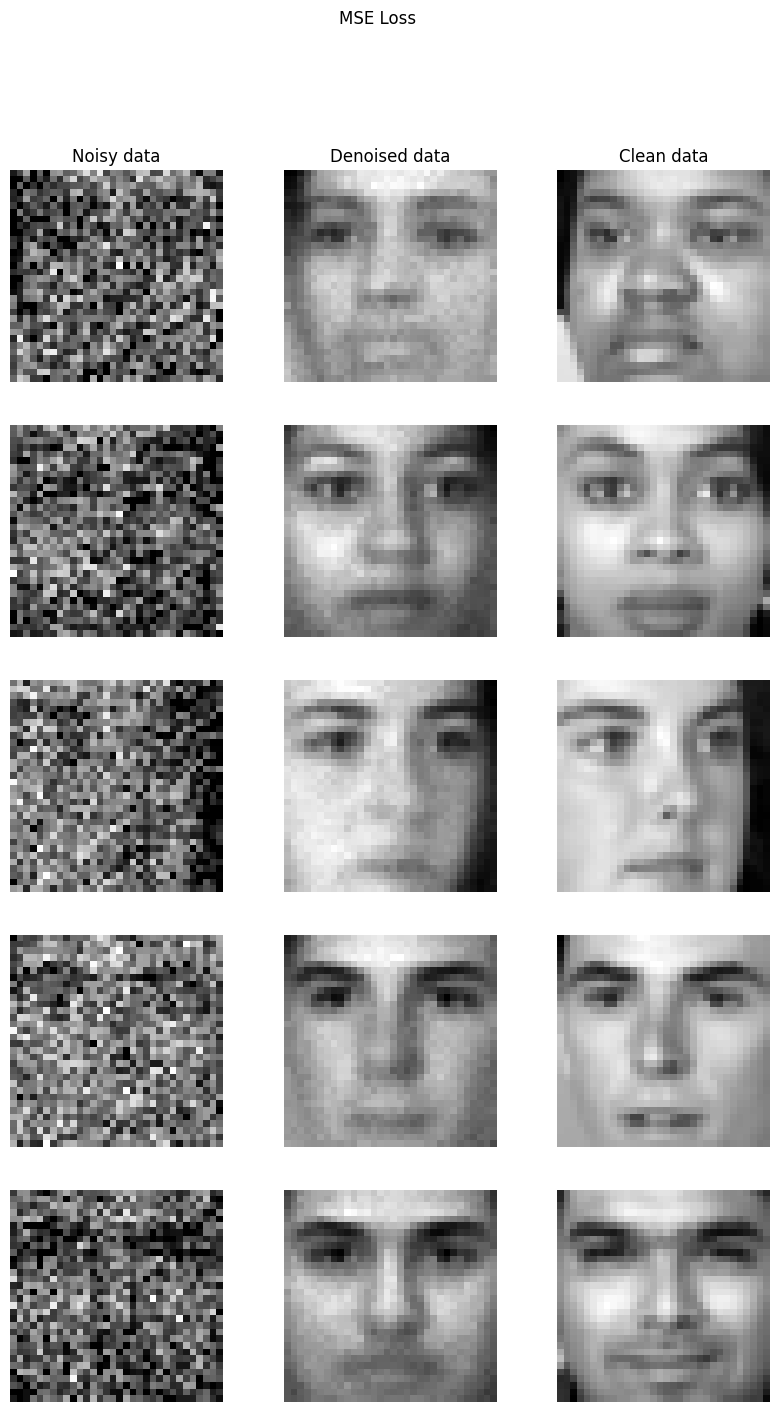

In [95]:
# visualize predictions along with noisy and clean input images using matplotlib
def visualize_preds(preds, title):
    predictions, noisy_data, clean_data = preds
    count = 5
    plt.figure(figsize=(10, 16))
    plt.suptitle(title)
    for i in range(count):
        plt.subplot(count, 3, i * 3 + 1)
        plt.imshow(noisy_data[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Noisy data")
        plt.subplot(count, 3, i * 3 + 2)
        plt.imshow(predictions[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Denoised data")
        plt.subplot(count, 3, i * 3 + 3)
        plt.imshow(clean_data[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Clean data")
    plt.show()


# Extract the predictions, noisy inputs, and clean inputs
params = torch.load("checkpoints_task_2/task_2_model_l1.ckpt")  # Load the best model
model_ae.load_state_dict(params["state_dict"])
pred = trainer_task.predict(model_ae, test_loader)
if pred is None:
    raise ValueError("No predictions made. Ensure the model is trained.")
visualize_preds(pred[0], "L1 Loss")


params = torch.load("checkpoints_task_2/task_2_model_mse.ckpt")  # Load the best model
model_ae.load_state_dict(params["state_dict"])
pred = trainer_task.predict(model_ae, test_loader)
if pred is None:
    raise ValueError("No predictions made. Ensure the model is trained.")
visualize_preds(pred[0], "MSE Loss")

<div class="alert alert-block alert-info">
    
### Task 2.5: Peak Signal To Noise Ratio (PSNR) <a class="anchor" id="t2_5"></a>
    
Here, you need to Compute Peak Signal-to-Noise Ratio (PSNR) for test dataset. The PSNR is a commonly used metric to measure the quality of a reconstructed or denoised signal or image. The PSNR is calculated as the ratio of the peak signal power to the noise power, typically measured in decibels (dB). PSNR can be defined as </br>
</br>
    $$\mathrm{PSNR} = 10 \cdot \log_{10}\Big\lbrace\frac{{\mathrm{MAX}^2}}{{\mathrm{MSE}}}\Big\rbrace$$

Where:

`PSNR` is the Peak Signal-to-Noise Ratio in dB.

`MAX` is the maximum possible pixel value (e.g., 255 for an 8-bit image).

`MSE` is the Mean Squared Error between the original and the reconstructed (or denoised) image. It's calculated as the average of squared pixel-wise differences between the two images.

Show the PSNR values for:
- Between the noisy image and original image
- Between the reconstructed image and original image

In [98]:
from torchmetrics.image import PeakSignalNoiseRatio

psnr = PeakSignalNoiseRatio()

# Put model into eval() mode so it turns off batch norm
model_ae.eval()

# Collect predictions and true labels
psnr_values_noisy_n_original = []
psnr_values_reconstructed_n_original = []

# Iterate over the entire test dataset and make predictions
# Make sure to use torch.no_grad below so that it does not keep track of gradients
with torch.no_grad():
    for batch in test_loader:
        pred = trainer_task.predict(model_ae, batch)
        if pred is None:
            raise ValueError("No predictions made. Ensure the model is trained.")
        predictions, noisy_data, clean_data = pred[0]
        psnr_noisy = psnr(noisy_data, clean_data)
        psnr_denoised = psnr(predictions, clean_data)
        psnr_values_noisy_n_original.append(psnr_noisy)
        psnr_values_reconstructed_n_original.append(psnr_denoised)


print(
    f"Mean PSNR value between noisy image and original image: {np.mean(psnr_values_noisy_n_original)}"
)
print(
    f"Mean PSNR value between reconstructed image and original image: {np.mean(psnr_values_reconstructed_n_original)}"
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Mean PSNR value between noisy image and original image: 9.938093185424805
Mean PSNR value between reconstructed image and original image: 22.367286682128906


<div class="alert alert-block alert-success">
    
### Task 2.6: Discussion Question <a class="anchor" id="t2_6"></a>
    
### Question:

1. How does the DAE reduce the amount of noise from the input?

2. Can you think of a reason why leaky ReLU was chosen over ReLU in this case?

3. What can you say about the PSNR values? Ensure you mention whether higher or lower PSNR values are better. 

4. How could we further improve the model? 
    
### Answer

1. The encoder part of the network compresses the noisy image which is then reconstructed by the decoder.
The noise is essentially simplified out of the image during the compression phase, which then gets reconstructed into some approximation of the original image.

2. Leaky ReLU is usually used in cases where dying neurons become a problem.

3. The PSNR of the reconstructed image to the original image is significantly lower than that between the noisy image and the original image (22.4 vs 9.9).
A higher PSNR is indicative of a more accurate image as the ratio of noise is lower.
 
4. Adding more hidden layers within the decoder and encoder would allow the autoencoder to fit more complex data and therefore improve quality of outputs.
Increasing the number of output neurons on the encoder might allow the encoder to pass more information to decoder for reconstruction, which could improve reconstructed image PSNR.